In [1]:
import sys
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from datetime import datetime
from itertools import combinations

In [2]:
PARAMETROS = {
    'task_type' : 'CPU',
    'has_time' : True,
    'silent' : True,
    'depth': 4,
    'early_stopping_rounds': 2,
    'iterations' : 100
}

In [3]:
#APERTURA ARCHIVOS
test = pd.read_pickle("Archivos/Arboles_validacion.pkl")
prediccion_arbol = pd.read_csv("Archivos/prediccion_arbol_validacion.csv")
prediccion_red   = pd.read_csv("Archivos/prediccion_naive_bayes_val.csv")
prediccion_arbol_test = pd.read_csv("Archivos/prediccion_arbol_test.csv")
prediccion_red_test   = pd.read_csv("Archivos/prediccion_naive_bayes.csv")

In [4]:
#ORDENO ARCHIVOS PARA QUE COINCIDA OPPORTUNITY_ID
test = test.sort_values('Opportunity_ID')
prediccion_arbol = prediccion_arbol.sort_values('Opportunity_ID')
prediccion_red   = prediccion_red.sort_values('Opportunity_ID')
prediccion_arbol_test = prediccion_arbol_test.sort_values('Opportunity_ID')
prediccion_red_test   = prediccion_red_test.sort_values('Opportunity_ID')
test_label = test['Stage']

In [5]:
prediccion_arbol = prediccion_arbol.groupby('Opportunity_ID').mean()
prediccion_arbol = prediccion_arbol.reset_index()
prediccion_red = prediccion_red.groupby('Opportunity_ID').mean()
prediccion_red = prediccion_red.reset_index()
test = test.sort_values('Opportunity_ID')
test = test.groupby('Opportunity_ID').mean()
test = test.reset_index()
test_label = test['Stage']

In [6]:
prediccion_red.count()

Opportunity_ID    2618
Target            2618
dtype: int64

In [7]:
prediccion_arbol.count()

Opportunity_ID    2618
Target            2618
dtype: int64

In [8]:
prediccion_red.head(5)

,Opportunity_ID,Target
0,7042,0.553246
1,7043,0.964904
2,7044,0.066558
3,7045,0.964086
4,7046,0.990127


In [9]:
prediccion_arbol.head(5)

,Opportunity_ID,Target
0,7042,0.538221
1,7043,0.539617
2,7044,0.465097
3,7045,0.549796
4,7046,0.521406


In [10]:
logs = []

In [11]:
#MAX
def ensamble_max():
    preds = prediccion_arbol['Target'].combine(prediccion_red['Target'], max, 0)
    print('Logloss Max: ', skl.metrics.log_loss(test_label,preds))
    logs.append(("Max",skl.metrics.log_loss(test_label,preds)))
    preds = prediccion_arbol_test['Target'].combine(prediccion_red_test['Target'], max, 0)
    return preds

In [12]:
#MIN
def ensamble_min():
    preds = prediccion_arbol['Target'].combine(prediccion_red['Target'], min, 0)
    print('Logloss Min: ', skl.metrics.log_loss(test_label,preds))
    logs.append(("Min",skl.metrics.log_loss(test_label,preds)))
    preds = prediccion_arbol_test['Target'].combine(prediccion_red_test['Target'], min, 0)
    return preds

In [13]:
#COMBINACION LINEAL
def ensamble_cl():
    min_a = -1
    min_b = -1
    min_logloss = 1000

    for a in range(0,100):
        for b in range(0,100):
            if(a == 0 & b == 0): continue
            preds = (a*prediccion_arbol['Target'] + b*prediccion_red['Target'])/(a+b)
            logloss = skl.metrics.log_loss(test_label,preds)
            if(logloss < min_logloss):
                min_logloss = logloss
                min_a = a
                min_b = b
    print("Logloss  CL:  %.16f (min_a : %i, min_b: %i)"% (min_logloss, min_a, min_b))
    logs.append(("Combinacion Lineal",skl.metrics.log_loss(test_label,preds)))
    preds = (min_a*prediccion_arbol_test['Target'] + min_b*prediccion_red_test['Target'])/(min_a+min_b)
    return preds

In [19]:
#KNN
def ensamble_knn():
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol['Target']
    temp['Red'] = prediccion_red['Target']
    temp['Stage'] = test_label
    entrenamiento = temp.iloc[:int(len(temp)/2),:]
    validacion = temp.iloc[int(len(temp)/2) + 1:,:]
    entrenamiento_label = entrenamiento.pop('Stage')
    classifier = KNeighborsClassifier(n_neighbors=300)
    classifier.fit(entrenamiento, entrenamiento_label)
    preds = classifier.predict_proba(validacion[['Arbol','Red']])
    print("Logloss KNN: ", skl.metrics.log_loss(validacion['Stage'],preds))
    logs.append(("KNN",skl.metrics.log_loss(validacion['Stage'],preds)))

    classifier.fit(temp[['Arbol','Red']], temp['Stage'])
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol_test['Target']
    temp['Red'] = prediccion_red_test['Target']
    preds = classifier.predict_proba(temp)
    preds = pd.Series([p[1] for p in preds])
    return preds

In [20]:
#Catboost

def ensamble_catboost():
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol['Target']
    temp['Red'] = prediccion_red['Target']
    temp['Stage'] = test_label
    entrenamiento = temp.iloc[:int(len(temp)/2),:]
    validacion = temp.iloc[int(len(temp)/2) + 1:,:]
    entrenamiento_label = entrenamiento.pop('Stage')
    entrenamiento_pool = cb.Pool(entrenamiento, entrenamiento_label)
    test_pool = cb.Pool(validacion)
    
    model = cb.CatBoostClassifier(**PARAMETROS)
    model.fit(entrenamiento_pool)
    preds = model.predict_proba(test_pool)
    preds = pd.Series([p[1] for p in preds])
    print("Logloss Cat: ", skl.metrics.log_loss(validacion['Stage'],preds))
    logs.append(("Catboost",skl.metrics.log_loss(validacion['Stage'],preds)))

    model.fit(temp[['Arbol','Red']], temp['Stage'])
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol_test['Target']
    temp['Red'] = prediccion_red_test['Target']
    test_pool = cb.Pool(temp)
    preds = model.predict_proba(test_pool)
    preds = pd.Series([p[1] for p in preds]) 
    return preds

def ensamble_naive_bayes():
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol['Target']
    temp['Red'] = prediccion_red['Target']
    temp['Stage'] = test_label
    entrenamiento = temp.iloc[:int(len(temp)/2),:]
    validacion = temp.iloc[int(len(temp)/2) + 1:,:]
    entrenamiento_label = entrenamiento.pop('Stage')
    
    model = GaussianNB(var_smoothing =0.5)
    model.fit(entrenamiento,entrenamiento_label)
    preds = model.predict_proba(validacion.drop(columns=["Stage"]))
    preds = pd.Series([p[1] for p in preds])
    print("Log   Bayes: ", skl.metrics.log_loss(validacion['Stage'],preds))
    logs.append(("Naive Bayes",skl.metrics.log_loss(validacion['Stage'],preds)))
    
    model.fit(temp[['Arbol','Red']], temp['Stage'])
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol_test['Target']
    temp['Red'] = prediccion_red_test['Target']
    preds = model.predict_proba(temp)
    preds = pd.Series([p[1] for p in preds]) 
    return preds

def ensamble_SVC():
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol['Target']
    temp['Red'] = prediccion_red['Target']
    temp['Stage'] = test_label
    entrenamiento = temp.iloc[:int(len(temp)/2),:]
    validacion = temp.iloc[int(len(temp)/2) + 1:,:]
    entrenamiento_label = entrenamiento.pop('Stage')
    
    model = SVC(probability = True)
    model.fit(entrenamiento,entrenamiento_label)
    preds = model.predict_proba(validacion.drop(columns=["Stage"]))
    preds = pd.Series([p[1] for p in preds])
    print("Logloss SVC: ", skl.metrics.log_loss(validacion['Stage'],preds))
    logs.append(("SVC",skl.metrics.log_loss(validacion['Stage'],preds)))
    
    model.fit(temp[['Arbol','Red']], temp['Stage'])
    temp = pd.DataFrame()
    temp['Arbol'] = prediccion_arbol_test['Target']
    temp['Red'] = prediccion_red_test['Target']
    preds = model.predict_proba(temp)
    preds = pd.Series([p[1] for p in preds]) 
    return preds

    


In [21]:
(prediccion_red['Target'] >= np.inf).value_counts()

False    2618
Name: Target, dtype: int64

In [22]:
#CALCULO Y SELECCION DE PREDS
print("Log Árboles: ",skl.metrics.log_loss(test_label,prediccion_arbol['Target']))
print("Logloss Red: ", skl.metrics.log_loss(test_label,prediccion_red['Target']))
preds_max = ensamble_max()
preds_min = ensamble_min()
preds_cl  = ensamble_cl()
preds_knn = ensamble_knn()
preds_catboost = ensamble_catboost()
preds_bayes = ensamble_naive_bayes()
preds_svc = ensamble_SVC()

Log Árboles:  0.5992482452464243
Logloss Red:  0.5447908049732779
Logloss Max:  0.4746114652617388
Logloss Min:  0.6694275849579634
Logloss  CL:  0.3888198537207205 (min_a : 8, min_b: 43)
Logloss KNN:  0.2991513288230852
Log   Bayes:  0.4053280841107024
Logloss SVC:  0.27038498754846546


In [ ]:
#GUARDADO DE ARCHIVOS
preds = preds_catboost
resultados = pd.DataFrame()
resultados['Opportunity_ID'] = prediccion_arbol_test['Opportunity_ID']
resultados['Target'] = pd.Series(preds)  
resultados.to_csv("Archivos/prediccion.csv", index=False)

In [ ]:
import matplotlib.style as style
plt.bar([l[0] for l in logs],[l[1] for l in logs])
plt.title("Log-Loss de cada algoritmo de Ensamble")
plt.ylabel("Log-Loss")
style.use("seaborn")
plt.show()

In [ ]:
fallar

In [ ]:
#REFINAMIENTO DE CATBOOST
#En caso de igualar/superar a KNN

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.model_selection import StratifiedKFold

temp = pd.DataFrame()
temp['Arbol'] = prediccion_arbol['Target']
temp['Red'] = prediccion_red['Target']
temp['Stage'] = test_label
entrenamiento = temp.iloc[:4000,:]
entrenamiento_label = entrenamiento.pop('Stage')
validacion = temp.iloc[4001:,:]
    
# Classifier
bayes_cv_tuner = BayesSearchCV(
estimator = CatBoostClassifier(
silent=True,task_type="CPU", bootstrap_type='MVS'
),
search_spaces = {
        "iterations" : (2, 10),
        'learning_rate': Real(low=0.01, high=1, prior='log-uniform'),
        "random_seed" : (1,40000),
        "l2_leaf_reg" : Real(low=1e-9, high=1000, prior='log-uniform'),
        'subsample': Real(low=0.01, high=1, prior='uniform'),
        "random_strength" : Real(low=1e-9, high=1000, prior='log-uniform'),
        'depth': (1, 10),
        #"rsm" : Real(low=0.01, high=1, prior='uniform'),
        "early_stopping_rounds" : (1, 5),
        "border_count" : (1,65535),
        "bagging_temperature" : Real(low=1e-9,high=1000,prior='log-uniform'),
        "scale_pos_weight" : Real(low = 0.01,high = 1.0,prior="uniform")
},
cv = skl.model_selection.TimeSeriesSplit(),
n_jobs = 1,
n_iter = 6,
verbose = 1,
refit = True,
random_state = 72
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
resultCAT = bayes_cv_tuner.fit(entrenamiento, entrenamiento_label, callback=status_print)

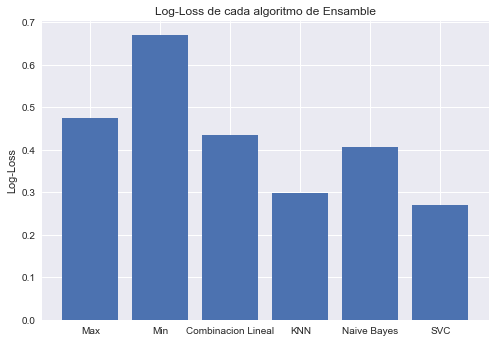